In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix, roc_curve, confusion_matrix, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

from pipelines import nested_cross_validate_score, pipeline_Donker
from transform import combine_tsv_files
from utils import double_cross_validate, get_sub_pipeline

In [2]:
# Difference genomic variable.
X, y = combine_tsv_files(
    "output/all__gene__up_or_down__No. Mutant Molecules per mL.tsv",
    "output/all__gene__up_or_down__CNV Score.tsv",
)

y_resp = y['response_grouped'].map({
    'non responder (sd+pd)': 'non responder (sd+pd+ne)', 
    'non evaluable (ne)': 'non responder (sd+pd+ne)',
    'responder (pr+cr)': 'responder (pr+cr)',
})

In [8]:
y_OS = y['OS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['OS_months'] < 12.0]['Censor_OS'] == 1.0)

y_PFS = y['PFS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['PFS_months'] < 12.0]['Censor_progression'] == 'progression of disease')

In [4]:
p = pipeline_Donker(CategoricalNB())

In [5]:
@double_cross_validate(5, 5)
def metrics_binary_class(clf, X, y, positive_class):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    class_index = list(clf.classes_).index(positive_class)
    y_prob = clf.predict_proba(X)[:, class_index]
    y_pred = clf.predict(X)
    fpr, tpr, _ = roc_curve(y, y_prob, pos_label=positive_class)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    metrics.update(
        {
            f"{positive_class}__tprs": interp_tpr,
            f"{positive_class}__fprs": mean_fpr,
            f"{positive_class}__roc_auc": roc_auc_score(y, y_prob),
            f"{positive_class}__accuracy": accuracy_score(y, y_pred),
            f"{positive_class}__confusion_matrix": confusion_matrix(
                y, y_pred, normalize="true"
            ),
        }
    )
    print(positive_class, roc_auc_score(y, y_prob))
    return metrics

In [6]:
@double_cross_validate(5, 5)
def multi_class_metrics(clf, X, y):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    # Make one v.s. rest classification.
    for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
        ybin_true = y == class_name
        class_index = list(clf.classes_).index(class_name)
        y_prob = clf.predict_proba(X)[:, class_index]
        ybin_pred = clf.predict(X) == class_name
        fpr, tpr, _ = roc_curve(ybin_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        metrics.update({
            f'{class_name}__tprs': interp_tpr,
            f'{class_name}__fprs': mean_fpr,
            f'{class_name}__roc_auc': roc_auc_score(ybin_true, y_prob),
            f'{class_name}__accuracy': accuracy_score(ybin_true, ybin_pred),
            f'{class_name}__confusion_matrix': confusion_matrix(ybin_true, ybin_pred, normalize='true'),
        })
        print(class_name, roc_auc_score(ybin_true, y_prob))
    return metrics

In [7]:
resp_mean, resp_std = metrics_binary_class(p, X, y_resp, positive_class="responder (pr+cr)")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.3s finished


responder (pr+cr) 0.7435897435897436
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


responder (pr+cr) 0.7222222222222222
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


responder (pr+cr) 0.6623931623931624
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


responder (pr+cr) 0.7136752136752137
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


responder (pr+cr) 0.64


In [9]:
OS_mean, OS_std = metrics_binary_class(p, X, y_OS, positive_class='>=1yr')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


>=1yr 0.6768707482993197
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


>=1yr 0.6802721088435374
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


>=1yr 0.7278911564625851
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


>=1yr 0.7006802721088435
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


>=1yr 0.7607142857142857


In [14]:
PFS_mean, PFS_std = metrics_binary_class(p, X, y_PFS, positive_class='>=1yr')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


>=1yr 0.7638888888888888
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


>=1yr 0.7916666666666666
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


>=1yr 0.670940170940171
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


>=1yr 0.7136752136752136
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


>=1yr 0.5144230769230769


In [10]:
def confusion_matrix_plot(metrics_mean, metrics_std, class_name, ax, labels):
    confusion_matrix_mean = pd.DataFrame(metrics_mean[f'{class_name}__confusion_matrix'], index=labels, columns=labels)
    confusion_matrix_std = pd.DataFrame(metrics_std[f'{class_name}__confusion_matrix'], index=labels, columns=labels)
    c_annot = confusion_matrix_mean.applymap(lambda x: '{:0.2f}$\pm$'.format(x)) \
        + confusion_matrix_std.applymap(lambda x: '{:0.2f}'.format(x))
    sns.heatmap(
        confusion_matrix_mean,
        annot=c_annot,
        fmt='',
        cmap=plt.cm.Blues,
        ax=ax,
        cbar=False,
    )
#     ax.set_yticks(rotation=0)
    ax.set_title(r'Accuracy {:0.2f}$\pm${:0.2f}'.format(metrics_mean[f'{class_name}__accuracy'], metrics_std[f'{class_name}__accuracy']))
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    return ax

In [11]:
def plot_roc_curve(m_mean, m_std, class_name, labels=None):
    plt.rc('font', family='serif')
    plt.figure(figsize=(4,3))
    fpr, tpr = m_mean[f'{class_name}__fprs'], m_mean[f'{class_name}__tprs']
    fpr_std, tpr_std = m_std[f'{class_name}__fprs'], m_std[f'{class_name}__tprs']
    tprs_upper = np.minimum(tpr + tpr_std, 1)
    tprs_lower = np.maximum(tpr - tpr_std, 0)

    fig, ax = plt.subplots()
    ax.set(
        xlim=[-0.05, 1.05], 
        ylim=[-0.05, 1.05],
        title=f"Receiver operating characteristic {class_name}",
    )
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    mean_label = r'Mean ROC (AUC = {:0.2f}$\pm${:0.2f})'.format(
        m_mean[f'{class_name}__roc_auc'], 
        m_std[f'{class_name}__roc_auc'],
    )
    print('Accuracy:', m_mean[f'{class_name}__accuracy'], )
    ax.plot(
        fpr, 
        tpr, 
        label=mean_label,
        lw=2,
    )
    ax.fill_between(fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                    label=r'$\pm$ 1 std. dev.')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(frameon=False, loc=2)
    inset_ax = ax.inset_axes([0.6, 0.15, 0.4, 0.4])
    if labels is None:
        label_abbrev = " ".join(class_name.split()[:-1]) \
            .replace('responder', "resp.") \
            .replace('evaluable', 'eval.')
        labels = ['rest', f'{label_abbrev}']
    confusion_matrix_plot(m_mean, m_std, class_name, inset_ax, labels=labels)

# Predicting responder vs non-evaluable and non-responders

Accuracy: 0.7356302521008404


<Figure size 288x216 with 0 Axes>

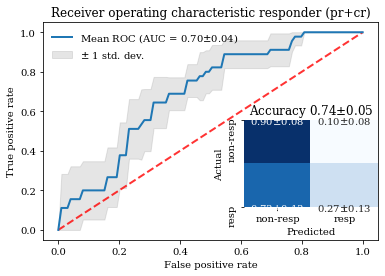

In [12]:
plot_roc_curve(resp_mean, resp_std, class_name='responder (pr+cr)', labels=['non-resp', 'resp'])
plt.savefig('response_prediction.png')

## Predicting overall survival

Accuracy: 0.6495798319327731


<Figure size 288x216 with 0 Axes>

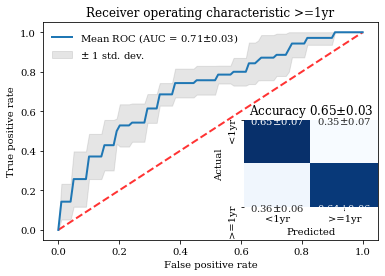

In [13]:
plot_roc_curve(OS_mean, OS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('os_prediction.png')

## Predicting progression free survival

Accuracy: 0.6998319327731093


<Figure size 288x216 with 0 Axes>

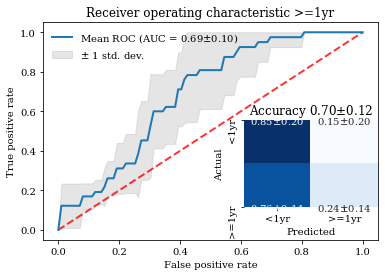

In [15]:
plot_roc_curve(PFS_mean, PFS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('pfs_prediction.png')

# Predicting responders, non-responders _and_ non-evaluable.

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.5s finished


non responder (sd+pd) 0.717391304347826
responder (pr+cr) 0.6367521367521367
non evaluable (ne) 0.7708333333333333
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.4s finished


non responder (sd+pd) 0.7101449275362318
responder (pr+cr) 0.7564102564102564
non evaluable (ne) 0.8541666666666666
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.4s finished


non responder (sd+pd) 0.677536231884058
responder (pr+cr) 0.6282051282051282
non evaluable (ne) 0.6666666666666666
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.7s finished


non responder (sd+pd) 0.6521739130434782
responder (pr+cr) 0.7136752136752137
non evaluable (ne) 0.5625
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.6s finished


non responder (sd+pd) 0.6742424242424242
responder (pr+cr) 0.6222222222222222
non evaluable (ne) 0.8817204301075269
Accuracy: 0.6899159663865546
Accuracy: 0.746890756302521
Accuracy: 0.9080672268907563


<Figure size 288x216 with 0 Axes>

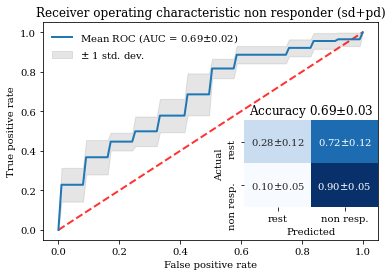

<Figure size 288x216 with 0 Axes>

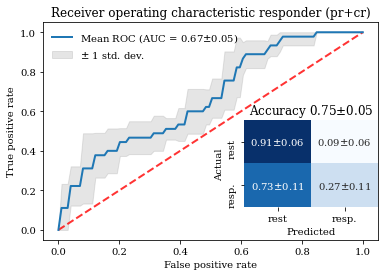

<Figure size 288x216 with 0 Axes>

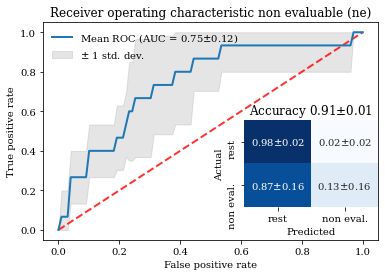

In [11]:
p.fit(X, y['response_grouped'])
m_mean, m_std = multi_class_metrics(p, X, y['response_grouped'])
for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
    plot_roc_curve(m_mean, m_std, class_name)